### Train a cats vs dogs classifier

In [1]:
import os
import cv2
import time
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid

from torchvision.models import efficientnet_b0

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DIR_TRAIN = "./train_cats_dogs/"

In [3]:
imgs = os.listdir(DIR_TRAIN) 

print(imgs[:5])

['dog.1564.jpg', 'dog.5155.jpg', 'dog.5943.jpg', 'dog.6978.jpg', 'dog.3523.jpg']


In [4]:
print(f"Number of images: {len(imgs)}")

Number of images: 25000


In [5]:
# mappa la classe ad un intero
class_to_int = {
    "cat" : 0,
    "dog" : 1
}

In [6]:
def get_train_transform():
    return T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(15),
        T.RandomCrop(204),
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
    
def get_val_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])

In [7]:
class CatDogDataset(Dataset):
    
    def __init__(self, imgs, class_to_int, mode = "train", transforms = None):
        
        super().__init__()
        self.imgs = imgs
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        image_name = self.imgs[idx]
        
        ### Reading, converting and normalizing image
        #img = cv2.imread(DIR_TRAIN + image_name, cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (224,224))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img /= 255.
        img = Image.open(DIR_TRAIN + image_name)
        img = img.resize((224, 224))
        
        if self.mode == "train" or self.mode == "val":
        
            ### Preparing class label
            label = self.class_to_int[image_name.split(".")[0]]
            label = torch.tensor(label, dtype = torch.float32)

            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label
        
        elif self.mode == "test":
            
            ### Apply Transforms on image
            img = self.transforms(img)

            return img
            
        
    def __len__(self):
        return len(self.imgs)

In [8]:
train_imgs, val_imgs = train_test_split(imgs, test_size = 0.25)

In [9]:
train_dataset = CatDogDataset(train_imgs, class_to_int, mode = "train", transforms = get_train_transform())
val_dataset = CatDogDataset(val_imgs, class_to_int, mode = "val", transforms = get_val_transform())

# batch_size was 16
BATCH_SIZE = 32

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 4,
    batch_size = BATCH_SIZE,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 4,
    batch_size = BATCH_SIZE,
    shuffle = True
)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
def accuracy(preds, trues):
    THR = 0.5
    
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= THR else 0 for i in range(len(preds))]
    
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)

In [12]:
def train_one_epoch(train_data_loader):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in tqdm(train_data_loader):
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        #Backward
        _loss.backward()
        optimizer.step()
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    # TODO: improve this one
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time

In [13]:
def val_one_epoch(val_data_loader, best_val_acc):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in val_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"resnet50_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc

In [14]:
model = efficientnet_b0(pretrained = True)

# Modifying Head, adding final classifier

model.classifier[1] = nn.Sequential(
    nn.Linear(1280, 1, bias = True),
    nn.Sigmoid()
)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /home/datascience/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [15]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Learning Rate Scheduler
# (LS): check, I don't think it is used
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 10

In [16]:
best_val_acc = 0

for epoch in range(epochs):
    
    ### Training
    loss, acc, _time = train_one_epoch(train_data_loader)
    
    # Print Epoch Details
    print()
    print(f"Training: Epoch {epoch}, Loss : {round(loss, 4)} Acc : {round(acc, 4)}, Time : {round(_time, 4)}")
    
    ### Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)
    
    # Print Epoch Details
    print()
    print(f"Validation: Epoch {epoch}, Loss : {round(loss, 4)} Acc : {round(acc, 4)}, Time : {round(_time, 4)}")

100%|██████████| 586/586 [01:11<00:00,  8.18it/s]


Training: Epoch 0, Loss : 0.0998 Acc : 96.7097, Time : 71.6271



Validation: Epoch 0, Loss : 0.0433 Acc : 98.2589, Time : 14.7116


100%|██████████| 586/586 [01:09<00:00,  8.42it/s]


Training: Epoch 1, Loss : 0.0367 Acc : 98.7735, Time : 69.6318



Validation: Epoch 1, Loss : 0.0337 Acc : 98.7054, Time : 12.7446


100%|██████████| 586/586 [01:09<00:00,  8.42it/s]


Training: Epoch 2, Loss : 0.0227 Acc : 99.2001, Time : 69.5876



Validation: Epoch 2, Loss : 0.0485 Acc : 98.8042, Time : 12.8728


100%|██████████| 586/586 [01:09<00:00,  8.42it/s]


Training: Epoch 3, Loss : 0.0142 Acc : 99.536, Time : 69.6299



Validation: Epoch 3, Loss : 0.0364 Acc : 98.8457, Time : 12.9024


100%|██████████| 586/586 [01:09<00:00,  8.42it/s]


Training: Epoch 4, Loss : 0.017 Acc : 99.3601, Time : 69.6244



Validation: Epoch 4, Loss : 0.044 Acc : 98.868, Time : 13.1209


100%|██████████| 586/586 [01:09<00:00,  8.41it/s]


Training: Epoch 5, Loss : 0.0134 Acc : 99.5307, Time : 69.6915



Validation: Epoch 5, Loss : 0.046 Acc : 98.9955, Time : 12.8093


100%|██████████| 586/586 [01:09<00:00,  8.40it/s]


Training: Epoch 6, Loss : 0.0096 Acc : 99.6694, Time : 69.7573



Validation: Epoch 6, Loss : 0.0271 Acc : 99.155, Time : 12.9733


100%|██████████| 586/586 [01:09<00:00,  8.42it/s]


Training: Epoch 7, Loss : 0.009 Acc : 99.733, Time : 69.6275



Validation: Epoch 7, Loss : 0.03 Acc : 99.0434, Time : 12.965


100%|██████████| 586/586 [01:09<00:00,  8.41it/s]


Training: Epoch 8, Loss : 0.0083 Acc : 99.7227, Time : 69.6986



Validation: Epoch 8, Loss : 0.0399 Acc : 99.1231, Time : 12.8069


100%|██████████| 586/586 [01:09<00:00,  8.40it/s]


Training: Epoch 9, Loss : 0.008 Acc : 99.7387, Time : 69.7976



Validation: Epoch 9, Loss : 0.0333 Acc : 98.9126, Time : 12.8068


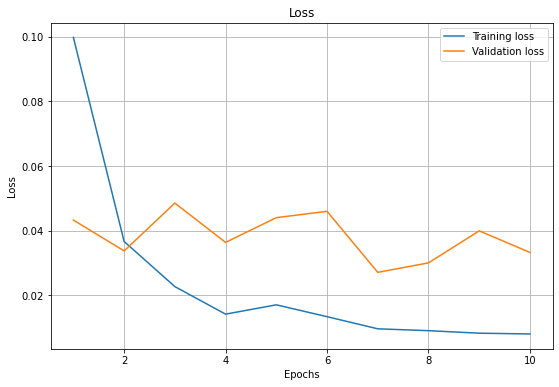

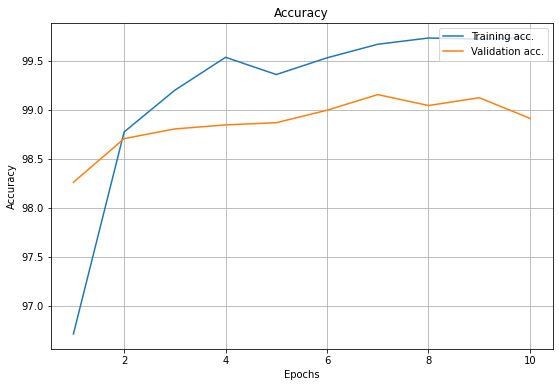

In [17]:
### Plotting Results

vet_epochs = np.arange(1, 11, 1)

# Loss
plt.figure(figsize=(9, 6))
plt.title("Loss")
plt.plot(vet_epochs, train_logs["loss"], label='Training loss')
plt.plot(vet_epochs, val_logs["loss"], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(9, 6))
plt.title("Accuracy")
plt.plot(vet_epochs, train_logs["accuracy"], label='Training acc.')
plt.plot(vet_epochs, val_logs["accuracy"], label='Validation acc.')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [18]:
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 